## Crassus: Development notes
---

In [195]:
# Python imports
#from Bio import SeqIO, SearchIO
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from ete3 import Tree, TreeStyle, TextFace, RectFace

#### Test run

`$ mamba create -c bioconda -c conda-forge --name dev_snakemake snakemake snakedeploy singularity` # to run the test\
`$ mamba create -c conda-forge -c bioconda --name utils biopython numpy pandas emboss blast` # env _utils.yaml_ \
`$ mamba create -c conda-forge -c bioconda --name phylogenies mafft trimal fasttree ete3 pandas` # env _phylogenies.yaml_\
`$ mamba create -c conda-forge -c bioconda --name clustering mmseqs2 pandas numpy` # env _clustering.yaml_\
`$ mamba create -c conda-forge -c bioconda --name compare_genomes pandas numpy pyani fastani blast` # env _compare_genomes.yaml_ \
`$ mamba create --name plot_genomes -c conda-forge -c r -c bioconda bioconductor-ggtree r r-biocmanager r-devtools` # env _plot_genomes.yaml

Singularity pull is not working so far. 

**First big test on 69 complete assemblies (the ancient ones)** \
`(dev_snakemake) danielc@mutant22:[SCREEN]:~/projects/crAssUS:snakemake -j70 --use-conda -p --reason` \
It taks quite a lot of time to download and install the packages of the envs. Maybe because it is a mutant, and I am writing to encode? Let's run it directly fromm the mutant.\
`(dev_snakemake) danielc@mutant23:[SCREEN]:/linuxhome/tmp/danielc/crAssUS:snakemake -j70 --use-conda -p --reason`

This error pops out, rule `get_marker_proteins`:\
`['-', '+'] Baboon22_45_164177_tbl-TGA portal                                                                                                                                                              
Traceback (most recent call last):                                                                                                                                                                         
  File "/linuxhome/tmp/danielc/crAssUS/.snakemake/scripts/tmp3kr0o04y.get_marker_genes.py", line 75, in <module>                                                                                           
    print(fragments)                                                                                                                                                                                       
NameError: name 'fragments' is not defined   `

I write a comment on GitHub regarding this. 

Lots of identified contigs seem very distant, ie. they don't cluster with any major family. Mmm what if I do a midpoint rooting? More of this in the `Taxonomy assessing` block.


---
## Bas & Berend 29/09/2021

I run all the primates, ancient, mexican and iceman samples in mutant4 so I can show this distant stuff (read above) to Bas and Berend tomorrow. But, I want to have a good tree. So I align with mafft and run iqtree instead of looking at my mafft(--add) & fasttree phylogeny. I have the reference terminases under mutant5. Grab them and merge with the crAssUS ones.

`(base) danielc@mutant5:/linuxhome/tmp/danielc/crassus_terl:cp fast/crass_reference_TerL.faa ~`\
`(crassus_dev) danielc@mutant14:/linuxhome/tmp/danielc:cat crAssUS/results/5_phylogenies/0_marker_genes/1_final/TerL.faa ~/crass_reference_TerL.faa > terl_distant/terl_ref_distant.faa`\
```
(crassus_dev) danielc@mutant14:/linuxhome/tmp/danielc/terl_distant:grep -c '>' terl_ref_distant.faa
>    1120
```

Align & trim: 

```
(mafft_env) danielc@mutant14:[SCREEN]:/linuxhome/tmp/danielc/terl_distant:mafft-einsi --thread 46 --quiet terl_ref_distant.faa > terl_ref_distant.mafft-einsi
(mafft_env) danielc@mutant14:[SCREEN]:/linuxhome/tmp/danielc/terl_distant:trimal -in terl_ref_distant.mafft-einsi -out terl_ref_distant_trim09.mafft-einsi -cons 60
```

Run iqtree:

```
(iqtree) danielc@mutant14:[SCREEN]:/linuxhome/tmp/danielc/terl_distant:iqtree -s terl_ref_distant_trim09.mafft-einsi --prefix iqtree/terl_ref_distant_trim09 -B 1000 -alrt 1000
```

While this is running, let's parse the Yutin's 2021 TerL tree. What a pain, but anyways. I create the `yutin` folder for it.

---
## Bas & Berend 07/10/2021

I already saw that the reason of some genomes being within the monophyletic clade of the crAssphage is not using the E-INS-I method. I want to show a tanglegram with the comparison. The R package for this is called `dendextend`, but it is a mess with more than 50 seqs. Also, it does not color the lines & branches if there are too many branches. What I can do then is **collapsing the tree at the family level** to show where this weird genomes are placed. But, first I want to have the comparative for the different alignment and tree methods. I create this structure:

```
(base) danielc@encode:~/projects/crAssUS/mafft_test:tree *add*
add
├── einsi
├── fftns1000
└── fftnsi
no_add
├── einsi
├── fftns1000
└── fftnsi
```

Let's align, trim and run fasttree:

```
# no add, 48 CPUs
(mafft_env) danielc@mutant14:[SCREEN]:~/projects/crAssUS/mafft_test:time mafft-fftnsi --maxiterate 1000 --thread 48 terl_ref_distant.faa > no_add/fftns1000/terl_ref_distant_fftns1000.faa ; time mafft-fftnsi --thread 48 terl_ref_distant.faa > no_add/fftnsi/terl_ref_distant_fftnsi.faa ; time mafft-einsi --thread 48 terl_ref_distant.faa > no_add/einsi/terl_ref_distant_einsi.faa

# add, 48 CPUs
(mafft_env) danielc@mutant14:[SCREEN]:~/projects/crAssUS/mafft_test:time mafft-fftnsi --maxiterate 1000 --thread 48 --add TerL.faa TerL_crassphage_reference.mafft-einsi > add/fftns1000/terl_ref_distant_fftns1000.faa ; time mafft-fftnsi --thread 48 --add TerL.faa TerL_crassphage_reference.mafft-einsi > add/fftnsi/terl_ref_distant_fftnsi.faa ; time mafft-einsi --thread 48 --add TerL.faa TerL_crassphage_reference.mafft-einsi > add/einsi/terl_ref_distant_einsi.faa

# trimm
(mafft_env) danielc@mutant14:[SCREEN]:~/projects/crAssUS/mafft_test:for msa in *add*/*/*.faa; do ~/software/trimAl/source/trimal -in $msa -out ${msa%.faa}_trim09.faa -gt 0.9 ;done

# build trees
(phylogenies) danielc@mutant14:[SCREEN]:~/projects/crAssUS/mafft_test:for msa in *add*/*/*_trim09.faa; do fasttree $msa > ${msa%.faa}_fasttree.nwk ; done
```

Collapse the trees at the family level. Include the tree from `mutant14` too. It is my gold standard since it was made with mafft-einsi and iqtree (automatic model selection)

```
(base) danielc@mutant14:/linuxhome/tmp/danielc/terl_distant/iqtree:cp terl_ref_distant_trim09.treefile ~/projects/crAssUS/mafft_test/gold_standard.nwk
```

In [64]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
import glob, os

# get only family
tax_file = "resources/crass_taxonomy.txt"
lines = [line.strip().split("\t") for line in open(tax_file).readlines()]
crass_taxonomy = {line[0]:line[2] for line in lines}
families = sorted(list(set([line[2] for line in lines])))
families.remove("outgroup")

trees = [tree_file for tree_file in glob.glob("mafft_test/*add/*/*.nwk") if not tree_file.endswith("_famcollpsd.nwk")]
trees += ["mafft_test/gold_standard.nwk"]


for tree_file in trees:
    print(tree_file)
    t = Tree(tree_file, format=1)

    for leaf in t.iter_leaves():
        genome = leaf.name.split("|")[0]
        if genome in crass_taxonomy:    
            leaf.add_features(family=crass_taxonomy[genome], genome=genome)
        else:
            leaf.add_features(family="new", genome=genome)

    outgs_leaves = t.search_nodes(family="outgroup")
    outgs_lca = t.get_common_ancestor(outgs_leaves)
    t.set_outgroup(outgs_lca)

    to_prune = list()
    for family in families:
        fam_leaves = t.search_nodes(family=family)
        fam_lca = t.get_common_ancestor(fam_leaves)
        fam_lca.name = family
        for child in fam_lca.get_children():
            child.detach()

    outfile = tree_file.replace(".nwk", "_famcollpsd.nwk")
    t.write(format=1, outfile=outfile)


mafft_test/add/fftnsi/terl_ref_distant_fftnsi_trim09_fasttree.nwk
mafft_test/add/fftns1000/terl_ref_distant_fftns1000_trim09_fasttree.nwk
mafft_test/add/einsi/terl_ref_distant_einsi_trim09_fasttree.nwk
mafft_test/no_add/fftnsi/terl_ref_distant_fftnsi_trim09_fasttree.nwk
mafft_test/no_add/fftns1000/terl_ref_distant_fftns1000_trim09_fasttree.nwk
mafft_test/no_add/einsi/terl_ref_distant_einsi_trim09_fasttree.nwk
mafft_test/gold_standard.nwk


What if I try `iqtree` in fast mode?

```
# fast, fftnsi
(iqtree) danielc@mutant14:~/projects/crAssUS/mafft_test/add/fftnsi:time iqtree -s terl_ref_distant_fftnsi_trim09.faa --prefix iqtree/terl_ref_distant_fftnsi_trim09 -m LG -T 47 -fast

# not fast, fftns1000. It does not solve the problem.
(iqtree) danielc@mutant14:[SCREEN]:~/projects/crAssUS/mafft_test/add/fftns1000:time iqtree -s terl_ref_distant_fftns1000_trim09.faa --prefix iqtree/terl_ref_distant_fftns1000_trim09 -m LG -T 47 -B 1000
```

So, apparently is because of the mafft alignment and not because of the phylogeny program (fasttree or iqtree). What I can do then is including mafft-einsi as an option. Good thing is that I can use the `--add` parameters, it did not affect the result as far I could see. Then, I include mafft-einsi and make it the default. I move previous classification results in `5_phylogenies` to `results_old`, and compare the results:

In [13]:
import pandas as pd
new = pd.read_csv("results/5_phylogenies/taxonomic_classification_completeness.txt", sep="\t", header=0, index_col=0)
old = pd.read_csv("results_old/5_phylogenies/taxonomic_classification_completeness.txt", sep="\t", header=0, index_col=0)

# iterate the genomes
cont = 0
for genome in new.index:
    check = False
    #for column in new:
    #    value_new = new.loc[genome, column]
    #    value_old = old.loc[genome, column]
    #    if value_new != value_old:
    #        check = True

I want to have a measure of how good my completeness estimates are. Because of this, I run checkv for all the candidate contigs:

```
(checkv_env) danielc@mutant14:[SCREEN]:~/projects/crAssUS/results_old/3_crass_contigs:for genome in *.fasta; do time checkv end_to_end $genome ~/no_borrar/checkv_all/${genome%.fasta} -d ~/danielc2/databases/checkv_database/checkv-db-v0.6 -t 47 ; done
```
Let's make a plot with the results

[54.5, 52.97]
Baboon19_180_98317 [100.0, 67.91]
Baboon22_161_97171 [100.0, 67.89]
Howler2_2157_20647 [20.87, 5.18]
Howler2_3654_14898 [15.06, 4.34]
Howler3_713_49917 [50.45, 26.13]
Lemur8_79_104328 [100, 7.17]
SRR12557716_73_90517 [100.0, 66.3]
SRR12557721_68_98131 [100, 89.92]


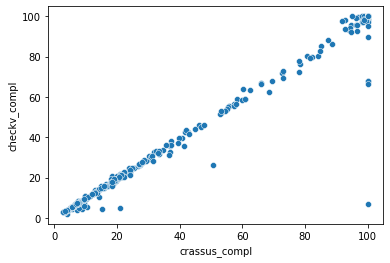

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import glob, os

# read completeness estimations
compl_values = dict()
table = pd.read_csv("results/5_phylogenies/taxonomic_classification_completeness.txt", sep="\t", header=0, index_col=0)
for genome in table.index:
    checkv_value = -1
    crassus_value = -1
    # read checkv file, get completeness
    checkv_file = f"/home/danielc/no_borrar/checkv_all/{genome}/quality_summary.tsv"
    if os.path.isfile(checkv_file):
        line = [line.strip().split("\t") for line in open(checkv_file).readlines()][1]
        if line[9] != "NA":
            checkv_value = float(line[9])
    # get crassus value
    if not pd.isna(table.loc[genome, "completeness"]):
        crassus_value = table.loc[genome, "completeness"]
        if crassus_value > 100:
            crassus_value = 100
    
    # add values
    if checkv_value != -1 and crassus_value != -1:
        compl_values[genome] = [crassus_value, checkv_value]

        
        
compl_df = pd.DataFrame.from_dict(compl_values, orient='index', columns=['crassus_compl', 'checkv_compl'])
sns.scatterplot(data=compl_df, x="crassus_compl", y="checkv_compl")
plt.savefig("borrar.png")
print(compl_values["Lemur1_367_53921"])

for genome, values in compl_values.items():
    if abs(values[0] - values[1]) > 10:
        print(genome,values)

---
### Reference crAss set

Originally I used all the genomes that we have (~2k), comprising complete and uncomplete genomes. Besides this might be too much redundancy, classification by ANI would be incorrect for uncomplete genomes. Because of this **I decide to use only the ones listed at `contigs_clustering.xlsx`, with the complete and taxonomically classified genomes from the proposal**. Using type species would be too few though. 

So, I change the whole reference set to include in the the container. 846 complete crAss genomes (excluding crass-env) in `contigs_clustering.xlsx`, but I still add the reference Bas' crass (crass001 is already in the list) and the two outgroups, so it makes 849 at the end. I change the .fasta files under `/genomes` and the proteins in `all_crass_proteins.faa` according to this. ⚠️ **WARNING** ⚠️ Because of the lack/split of TerL gene in 8 genomes, the final number is 841, read below.

Regarding the terminases, I extract them with Biopython. I grab all the trimmed, merged terminases from `bas/february_2021/terLterL_sequences_trimmed_merged.faa`:

In [20]:
# read "crassus_genomes.txt" with the target genomes ids
target_genomes = [line.strip() for line in open("crassus_genomes.txt").readlines()]

# read the .faa file with all the terminases. Store the ones from the target genomes
to_write = list()
records = SeqIO.parse("container/terL_sequences_trimmed_merged.faa", "fasta")
for record in records:
    genome = record.id.split("|")[0]
    if genome in target_genomes:
        to_write.append(record)
        target_genomes.remove(genome)
        
with open("container/crass_reference_TerL.faa", "w") as fout:
    SeqIO.write(to_write, fout, "fasta")
                
# print genomes without a final TerL protein 
print(target_genomes)
len(target_genomes)

['3300008523_____Ga0115231_1000095', 'OAWB01000083', '3300014553_____Ga0134451_100057', 'ERR589831_NODE_127_length_97341_cov_28.7607', 'OLOZ01000093', 'OLQU01000060', 'ERR589503_NODE_260_length_95985_cov_44.2112', 'ERR589804_NODE_183_length_96082_cov_14.9851']


8

Note well the 8 genomes without a TerL gene. **I remove them from the reference set so far**. 

In [21]:
# remove them from the genomes folder
for genome in target_genomes:
    if os.path.isfile(f"container/genomes/{genome}.fasta"):
        print(f"deleting {genome} genome")
        os.remove(f"container/genomes/{genome}.fasta")
        
# remove them from `all_crass_proteins.faa` 
to_write = list()
records = SeqIO.parse("container/all_crass_proteins.faa", "fasta")
for record in records:
    genome = record.id.split("|")[0]
    if genome not in target_genomes:
        to_write.append(record)

with open("container/all_crass_proteins.faa", "w") as fout:
    SeqIO.write(to_write, fout, "fasta")

---
### TerL tree + rest of the trees (MCP, portal?, primase?)

The reference set are 841 genomes with their proteins and terminases. I don't know how long is gonna take to align all these sequences + the sequences found by the pipeline.

`mafft-einsi` took 15 mins with 841 seqs and 93 CPUs.
- `(mafft_env) danielc@mutant5:/linuxhome/tmp/danielc/crassus_terl:time mafft-einsi --thread 93 --quiet crass_reference_TerL.faa > crass_reference_TerL.mafft-einsi`

Let's parse the tree. I want to get as much classification as I can from it. The approach I follow is looking at two uppper nodes and checking if the family/subfamily/genus is the same.

`fasttree` was quick making the tree ofc. But what about iqtree in its fastest mode? Let's run it with the reference genomes to know how long it takes and to measure the distances inter and intra genera.\
`(iqtree) danielc@mutant5:[SCREEN]:/linuxhome/tmp/danielc/crassus_terl:time iqtree -fast -T 90 -s crass_reference_TerL.mafft-einsi -B 1000 -alrt 1000`

One of the drawbacks I see is the model estimation takes too long.


Time to get the sequences for the rest of the markers. Let's start with **MCP**. This is a very split gene, but it should be easy to get it full-length since I already merged them based on the merge/leave analysis. Just look at the `3_merged` genome tables. Script `borrar/mcp/gather/mcps.py`. Most of them are OG_824 & OG_825:

1109 OG_824\
565 OG_825\
133	OG_827\
84	OG_669\
17	OG_826\
10	OG_223\

Get the MCPs faa:\
`(base) danielc@encode:~/borrar/mcp:python get_mcps.py`

Align it:\
`(mafft_env) danielc@mutant5:~/borrar/mcp:mafft-einsi --thread -1 MCP_crassphage_reference.faa > MCP_crassphage_reference.mafft-einsi`

Same for portal.

**I decide not using primase since it is not found neither in Epsilon nor in outgroup**

---
### mmseqs2 clustering

I already have implemented most of it, but still have to assess the cutoff values to delimitate genera. In the proposal it is 80% of shared content using OrthoMCL. 

Last time I tried to calculate this shared content for all the genomes, but it was too intensive for my computer/CPUs, the matrix is too big to fill it in a reasonable amount of time. However, I wrote a multithreaded script for this long time ago, `create_shared-content_from_presabs.py`. Diretory `/home/danielc/borrar/shared_content` under encode, I copy all the files there.

`(base) danielc@mutant5:~/borrar/shared_content:python create_shared-content_from_presabs.py -i presabs_matrix.txt -f all_proteins.faa -o shared_content_all.txt`

Let's plot the results 

In [7]:
# read taxonomy file and save it in a dict
crass_taxonomy = dict()

tax_file = "resources/crass_taxonomy.txt"
lines = [line.strip().split("\t") for line in open(tax_file).readlines()]
for line in lines:
    crass_taxonomy[line[0]] = {
                               "family":line[2],
                               "subfamily":line[3],
                               "genus":line[4]
                              }


# get the order of the gneomes in the tree
tree_file = "results/5_phylogenies/2_trees/TerL_trimmed.nwk"
t = Tree(tree_file, format=1)
#t.show()
# find the LCA of the two outgroup species
outgs_leaves = t.search_nodes(name="NC_021803|775|90") 
outgs_leaves += t.search_nodes(name="TARA_MK892509|880|3")
outgs_lca = t.get_common_ancestor(outgs_leaves)
# reroot the tree 
t.set_outgroup(outgs_lca)
# iterate the leafs and store the order
tree_order = list()
for leaf in t.iter_leaves():
    genome = leaf.name.split("|")[0]
    tree_order.append(genome)

tree_order[:10]

['NC_021803',
 'TARA_MK892509',
 'ERR1094784_126_24149',
 'ERR1094785_24_69983',
 'ERR1094786_103_58540',
 'ERR1094787_10_70013',
 'ERR1094789_20_69998',
 'ERR1094791_38_70090',
 'ERR1094792_485_14433',
 'ERR1094793_8_69890']

In [ ]:
# read the shared content table and re-order it according to the tree
matrix_file = "~/no_borrar/shared_content/shared_content_all.txt"
df = pd.read_csv(matrix_file, sep="\t", index_col=0)

# reorder columns
df = df[tree_order]
# reorder rows
df = df.reindex(tree_order)

In [ ]:
df.loc["ERR589440_NODE_115_length_101302_cov_10.743",:]

Colors of the heatmap in the proposal are from the **Spectral** R palette, which is not available in Matplotlib. To get the color codes, I use [this](https://gist.github.com/jtoll/4021792) running R directly in the encode's shell (since I don't have R installed in my Toshiba right now).

Colors are below. Remove first and last and you are ready to go (9 colors + white of 0-10% of shared content):\
"#9E0142", "#D53E4F", "#F46D43", "#FDAE61", "#FEE08B", "#FFFFBF", "#E6F598", "#ABDDA4", "#66C2A5", "#3288BD", "#5E4FA2"

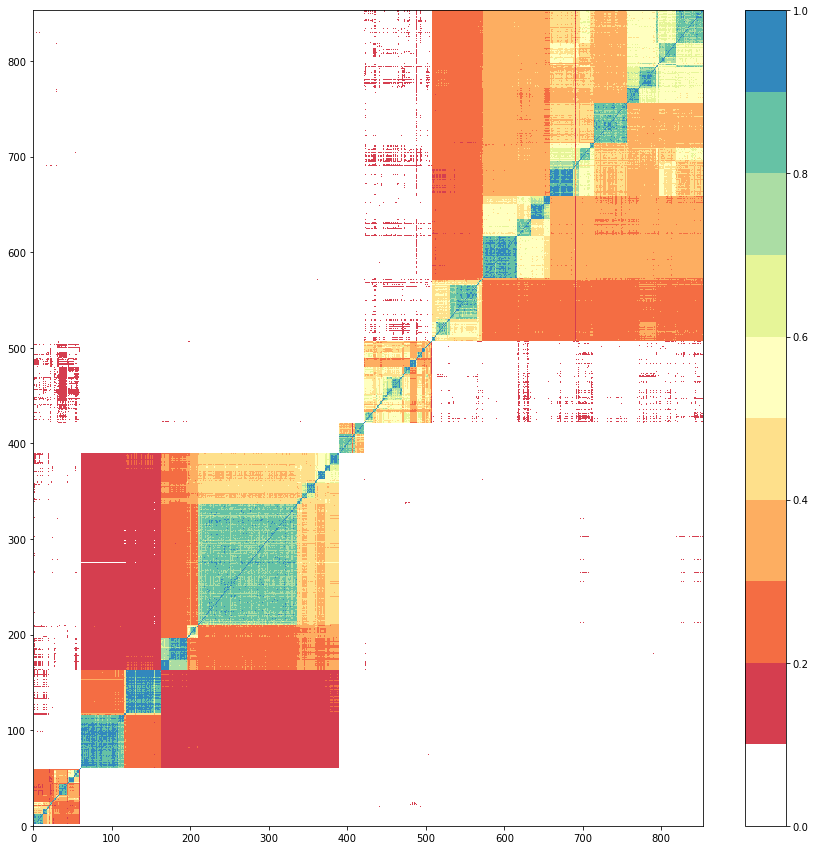

In [88]:
# draw the heatmap
cmap = colors.ListedColormap(["white", "#D53E4F", "#F46D43", "#FDAE61", "#FEE08B", "#FFFFBF", "#E6F598", "#ABDDA4", "#66C2A5", "#3288BD"])
bounds= np.arange(0,1, 0.1).tolist()
plt.rcParams["figure.figsize"] = (15,15)
heatmap = plt.pcolor(df, cmap=cmap)
plt.colorbar(heatmap, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

Heatmap shows that, in overall, values of shared protein content are lower than in the proposal. This agrees with what I saw of mmseqs2 being less sensitive than Broccoli, ie. creating more clusters. This should not be a problem as long as I find a proper cutoff to delimitate genera with this approach. 

I want to check 3 things:
- minimum value of sharing within the same genus
- maximum value of sharing between different genera

In [11]:
# store the shared content values within the same genus and between different genera
within_genus   = list()
between_genera = list()

# compute it only for the ref crassphages, discard output and found by crAssUS
genomes = [genome for genome in df.index.tolist() if genome in crass_taxonomy and genome not in ["NC_021803", "TARA_MK892509"]]

for query in genomes:
    for ref in genomes:
        if crass_taxonomy[query]["genus"] == crass_taxonomy[ref]["genus"]:
            within_genus.append(df.loc[query, ref])
        else:
            between_genera.append(df.loc[query, ref])
            
# put everything in the same df
dataset = ["within_genus"] * len(within_genus) + ["between_genera"] * len(between_genera)
values  = within_genus + between_genera
to_df = [[kind, value] for kind, value in zip(dataset, values)]

In [ ]:
df_sharedc = pd.DataFrame(to_df, columns=["dataset", "value"])
df_sharedc

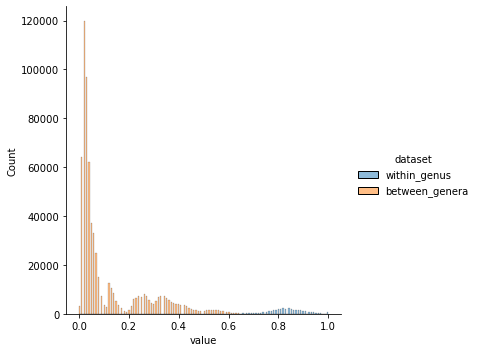

In [17]:
sns.displot(df_sharedc, x="value", hue="dataset")
plt.savefig("borrar2.png")

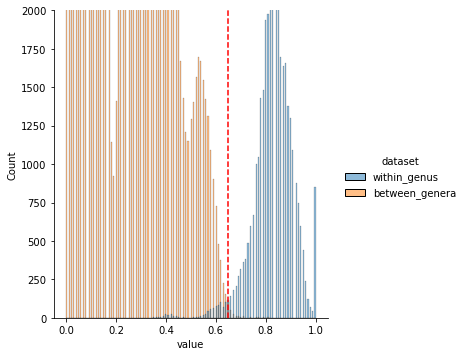

In [18]:
sns.displot(df_sharedc, x="value", hue="dataset")
plt.ylim(0, 2000)
plt.axvline(0.65, color="r", linestyle="--")
plt.savefig("borrar3.png")

#### Reference crAssphages
I want to repeat what I did for the genus, but for all the ranks, to see if I can use that information to classify doubtful crAssphages. I use only the reference genomes then. First, cluster them and create presabs and sharing matrices:

```
(mmseqs2) danielc@mutant1:~/no_borrar/shared_content/only_reference:mmseqs createdb all_crass_proteins.faa  db/all_crass_proteins

(mmseqs2) danielc@mutant1:~/no_borrar/shared_content/only_reference:mmseqs cluster db/all_crass_proteins clustering tmp/ -c 0 --threads 95 -s 6 --cluster-steps 4 --cluster-reassign

(mmseqs2) danielc@mutant1:~/no_borrar/shared_content/only_reference:mmseqs createtsv db/all_crass_proteins db/all_crass_proteins clustering clustering.tsv

# NB the change in environment. It crashes in the mmseqs2 one because of an old version of pandas
(base) danielc@mutant1:~/no_borrar/shared_content/only_reference:python create_presabs_matrix.py

(base) danielc@mutant1:~/no_borrar/shared_content/only_reference:python create_shared-content_from_presabs.py -i presabs_matrix.txt -f all_crass_proteins.faa -o shared_content_reference.txt
```

Parse the results:

(841, 841)
Crevaviridae
Intestiviridae
Jelitoviridae
Steigviridae
Suoliviridae
Tinaiviridae


(0.0, 1000.0)

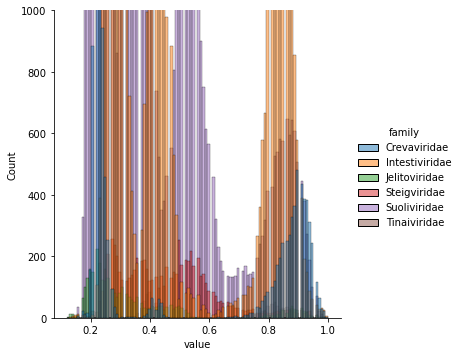

In [58]:
# start by reading the sharing file to get the genomes that underwent the clustering. Remember I discarded 5 at the beginning because of they lacking TerL
df = pd.read_csv("/home/danielc/no_borrar/shared_content/only_reference/shared_content_reference.txt",
                header=0, index_col=0, sep="\t")
print(df.shape)
clustered_genomes = df.columns

tax_file = "resources/crass_taxonomy.txt"

# genomes as key
genomes_taxa = dict()
lines = [line.strip().split("\t") for line in open(tax_file).readlines() if line.split("\t")[0] in clustered_genomes]
for line in lines:
    genomes_taxa[line[0]] = {
                               "family":line[2],
                               "subfamily":line[3],
                               "genus":line[4]
                              }

# taxa as key
families_genomes = {family:list() for family in sorted(list(set([line[2] for line in lines if "outgroup" not in line])))}
subfamilies_genomes = {subfamily:list() for subfamily in list(set([line[3] for line in lines if "outgroup" not in line ]))}
genera_genomes = {genus:list() for genus in list(set([line[4] for line in lines if "outgroup" not in line]))}
for line in lines:
    if "outgroup" not in line:
        families_genomes[line[2]].append(line[0])
        subfamilies_genomes[line[3]].append(line[0])
        genera_genomes[line[4]].append(line[0])




values = list() 
for family in families_genomes:
    print(family)
    for qgenome in families_genomes[family]:
        for rgenome in families_genomes[family]:
            if qgenome != rgenome:
                value = df.loc[qgenome, rgenome]
                values.append([value, family])
                
values_df = pd.DataFrame(values, columns=["value", "family"])
sns.displot(values_df, x="value", hue="family")
plt.ylim(0, 1000)

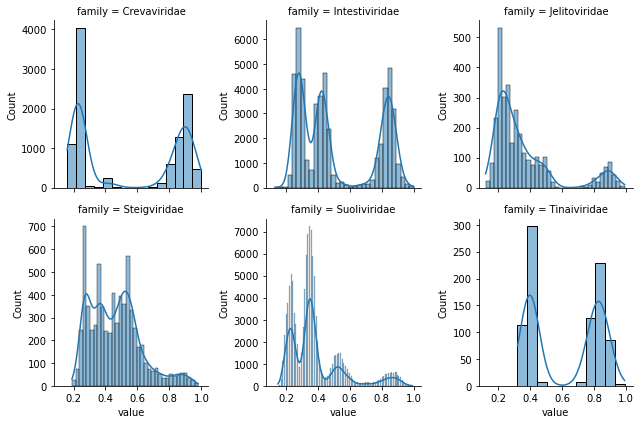

In [65]:
g = sns.FacetGrid(values_df, col="family", sharey=False, col_wrap=3)
g.map(sns.histplot, "value", kde=True)

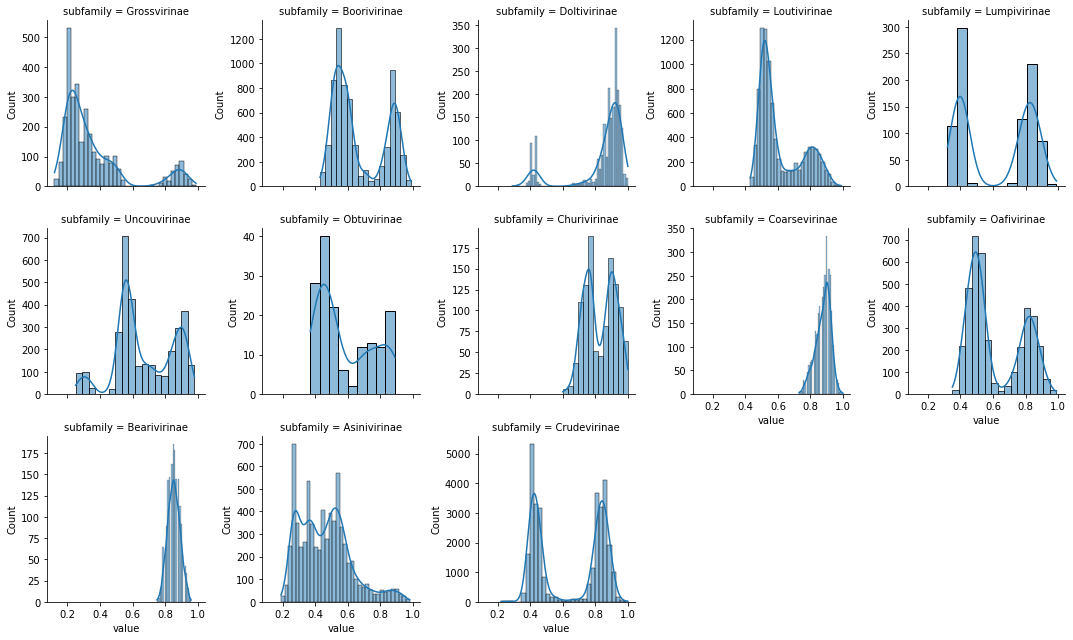

In [67]:
values = list() 
for subfamily in subfamilies_genomes:
    for qgenome in subfamilies_genomes[subfamily]:
        for rgenome in subfamilies_genomes[subfamily]:
            if qgenome != rgenome:
                value = df.loc[qgenome, rgenome]
                values.append([value, subfamily])
                
values_df = pd.DataFrame(values, columns=["value", "subfamily"])
#sns.displot(values_df, x="value", hue="subfamily")
#plt.ylim(0, 1000)

g = sns.FacetGrid(values_df, col="subfamily", sharey=False, col_wrap=5)
g.map(sns.histplot, "value", kde=True)

---
### Draw genomes

Let's do something more relaxing, let's draw the genomes' alignments. BioPython GenomesDiagram's are ugly as fuck, so let's give it a try to gnoplotr. That means that I need to install R, both in my toshiba and the container. For the toshiba I follow [this link](https://linuxize.com/post/how-to-install-r-on-ubuntu-20-04/), for the container I use mamba for the version 4.1. Development under the `genomes_graphs_dev` folder, Rnotebook. ⚠️ **too shity** ⚠️ Let's move with the next method.

I was trying to avoid EasyFig, but it might be my best shot. It can be run from the command line too.

**I ask Petros about a package for this: he says there is one actually, but is busy right now and will send it to me later.** Well, the package is [clinker](https://github.com/gamcil/clinker/blob/master/images/figure.png). It might be nice, but first drawback is that it needs genbank files. 

Let's move forward with `genoplotR` for now. This is what I will need:

1) Which kind of alignment should I expect from Blast? 

x) Reorder genomes to make them start from the terminase gene. **What if the genome found does not contain a terminase?**

---
### Taxonomy assessing

I have some difficulties using singularity containers for this. NB that I need an environment with ete3 and a file with the taxonomy for the reference crassphages. It seems that the `container` directive does not work well with the `script` one, since I am not able to import ete3 using the latter. However, it works using a conda environment instead.

`mamba create -c conda-forge -c bioconda -c etetoolkit -n ete3_env ete3`\
`conda env export --name ete3_env > ete3_env.yaml`

Some of the TerL identified in the big test (all the ancient, monkeys samples) seem to be very distant. Maybe even more than the two usual outgroups. 

- TerL tree of the 841 species in `TerL_crassphage_reference.mafft-einsi`. I do it with FastTree so far. **midpoint rooting of this tree(**`TerL_crassphage_reference.nwk`) **places the two outgroups outside of the crAss clade**.

- TerL tree of ALL the crassphages of my project, from `february_2021`. 

It is fine, after a meeting with Bas we agree that the outgroup is not that important. Maybe we find even better outgroups, ie. more distant. So, let's continue using the outgroups from Yutin. 

Something I notice is that what I called "Approach 2" in `parse_terl_tree.ipynb` fails in very populated clades with new contigs only because this approach only loos 2 nodes up. Look for instance at these new genomes, they should be annotated at least as _Steigviridae, Asinivirirane_, but are left blank. 

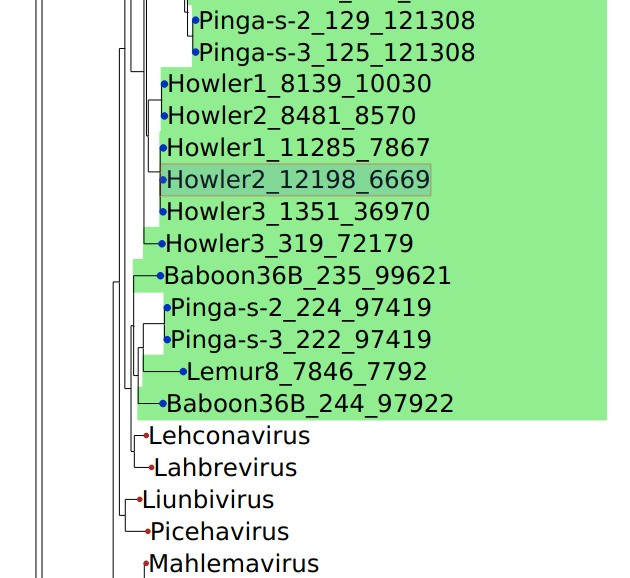

So, the only thing I can think of is following the Approach 1, where I find the LCA for each rank and then the new genomes that fall within each of them. BUT for that each of the ranks has to be monophyletic. I recall there were some that were not. To check that everything is fine with the tree, I build one only with the references and IQtree.

`(iqtree) danielc@mutant5:[SCREEN]:/linuxhome/tmp/danielc/crassus_terl/normal:time iqtree -T 90 -s crass_reference_TerL.mafft-einsi -B 1000 -alrt 1000`

Actually, I think it would be better not doing something weird changing the taxonomy (doing Uncouvirinae_1 and so) and just annotate the inner nodes. Then, for each of the new genomes, go deeper in the tree until the family/subfamily/genus agrees. **I realize that I need to know where the LCA of a genus (for instance, applies to all ranks) is. With the so-called _aproach 3_ I don't how to discern between two scenarios: new genome within a genus clade, and new genus being the sister clade of a genus clade. When looking at the upper node, in both scenarios is gonna be [genus, "new"]. So I can not say "yeah if in the childs contain only genus X and a new genome, call it as genus X too".** \
So, I need monophylectic clades. Changes to the taxonomy are under `/home/danielc/projects/crAssUS/resources/terl_fixed_monophyl_tax.txt`. Notice that the same needs to be done for the MCP. Let's go for it. Done. Now the same for the portal:

- Genomes OHFV01000001, OLXR01000011, QRFC01000022, TARA_MK892509 and NC_021803 were not annotated with the portal profile:
    - **NC_021803**, portal is NC_021803|812|91	OG_2062
    - **TARA_MK892509**, portal is TARA_MK892509|808|5 OG_2062
    - **OHFV01000001**, portal is OHFV01000001|734|116
    - **OLXR01000011**, portal is OLXR01000011|734|207
    - **QRFC01000022**, portal is QRFC01000022|734|190 
    
For the genomes where more than one portal is found, grab only **OG_48**. 844 at the end of the process. 

`(mafft_env) danielc@encode:~/borrar/portal:mafft-einsi --thread 10 portal_crassphage_reference.faa > portal_crassphage_reference.mafft-einsi`

Let's see how fucked up the monophylic clades are in the portal tree. Not that much :)

The result of cell above is a table called `taxonomic_classification_completeness.txt` with the taxa classifications based on the marker's trees. Now I have to **figure out how to use the protein sharing information**. 

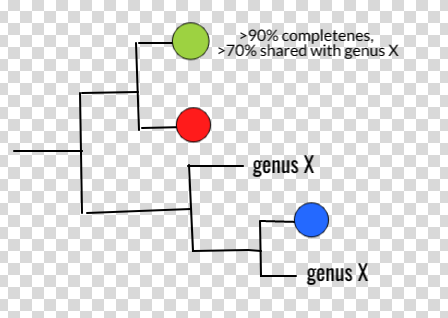

Let's say I have tree above. My goal is to classify as many genomes as possible. Blue genome is clearly genus X based on the tree, but is not that clear for green and red genomes. Looking at protein sharing I know that the green one is genus X too. However, I can not do the same for red genome because the completenes is very low. But I can say it is genus X too because now it is part of a monophyletic clade for genus X. But first let's get which genomes share enough proteins with others to be considered part of the same genus.

I don't like the way I assign taxonomies in the tree, looking for the monophyletic clade of the corrected taxonomy. It is very likey that the topology changes in the crAssUS tree, and my corrected clades would not be monophyletic anymore. I need to correct that, and what I do is something quite simple actually. I use an ete3 function like this `get_monophyletic_clade(values=[genus, "new")` to get all the clades containing only _genus_ AND _new_. It needs to contain both. Then I look for the lca of _genus_ so I leave out of the monophyletic clade the deepest nodes containing only _new_ genomes. Way easier than what I tried before tbh.

I have noticed that the way I align affects the topology of the tree. Using mafft (__FFT-NS-2__ by default) + fasttree gives a tree with a weird topology, with a clade with long branches within the monophyletic clade of the crassphages. Also, the Jelitoviridae is not the deepest clade anymore.

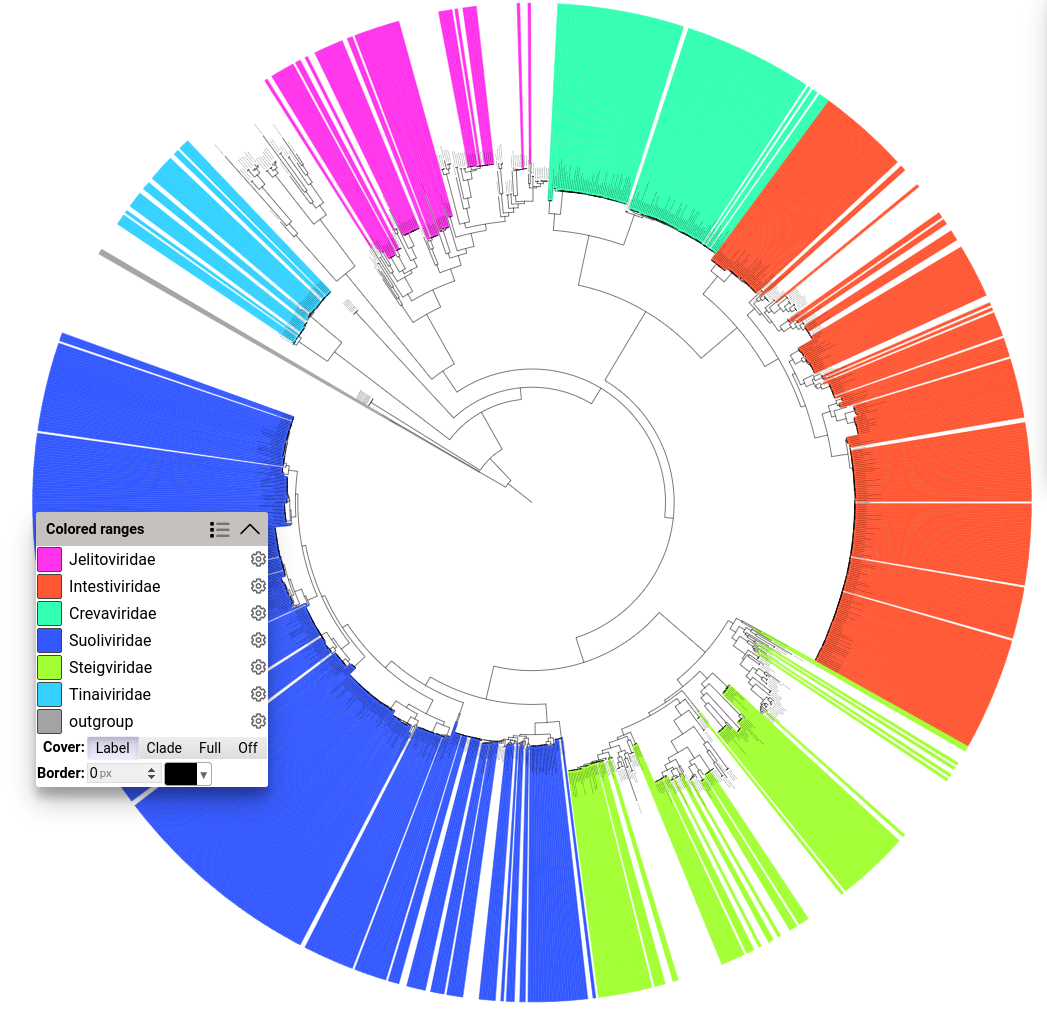

However, using mafft-einsi this clade is left out and is closer to the outgroup. I trust more the latter one. So mafft-einsi is better, but it takes too long to finish. So I want to try intermediate approaches, look at this [site](https://mafft.cbrc.jp/alignment/software/algorithms/algorithms.html) with the details of the mafft algorithm. 

__FFT-NS-2__ is too rough, so let's try with more iterations. 

- __mafft-fftnsi__, 2 iterations by default. 3 minutes.

```
(mafft_env) danielc@encode:~/projects/crAssUS:time mafft-fftnsi --add results/5_phylogenies/0_marker_genes/1_final/TerL.faa --thread 4 resources/MSAs/TerL_crassphage_reference.mafft-einsi > mafft_test/mafft-einsi.fftnsi
```

- __mafft-fftnsi__, 1000 iterations. 5 minutes.

```
(mafft_env) danielc@encode:~/projects/crAssUS:time mafft-fftnsi --maxiterate 1000 --add results/5_phylogenies/0_marker_genes/1_final/TerL.faa --thread 4 resources/MSAs/TerL_crassphage_reference.mafft-einsi > mafft_test/mafft-einsi.fftnsi1000

```

I trim (-gt 0.9) and make a phylogeny with both. The default with 2 iterations already solves the problem, also the 1k iterations one. Actually they are identical. **READ BELOW, IT DOES NOT SOLVE THE PROBLEM**.

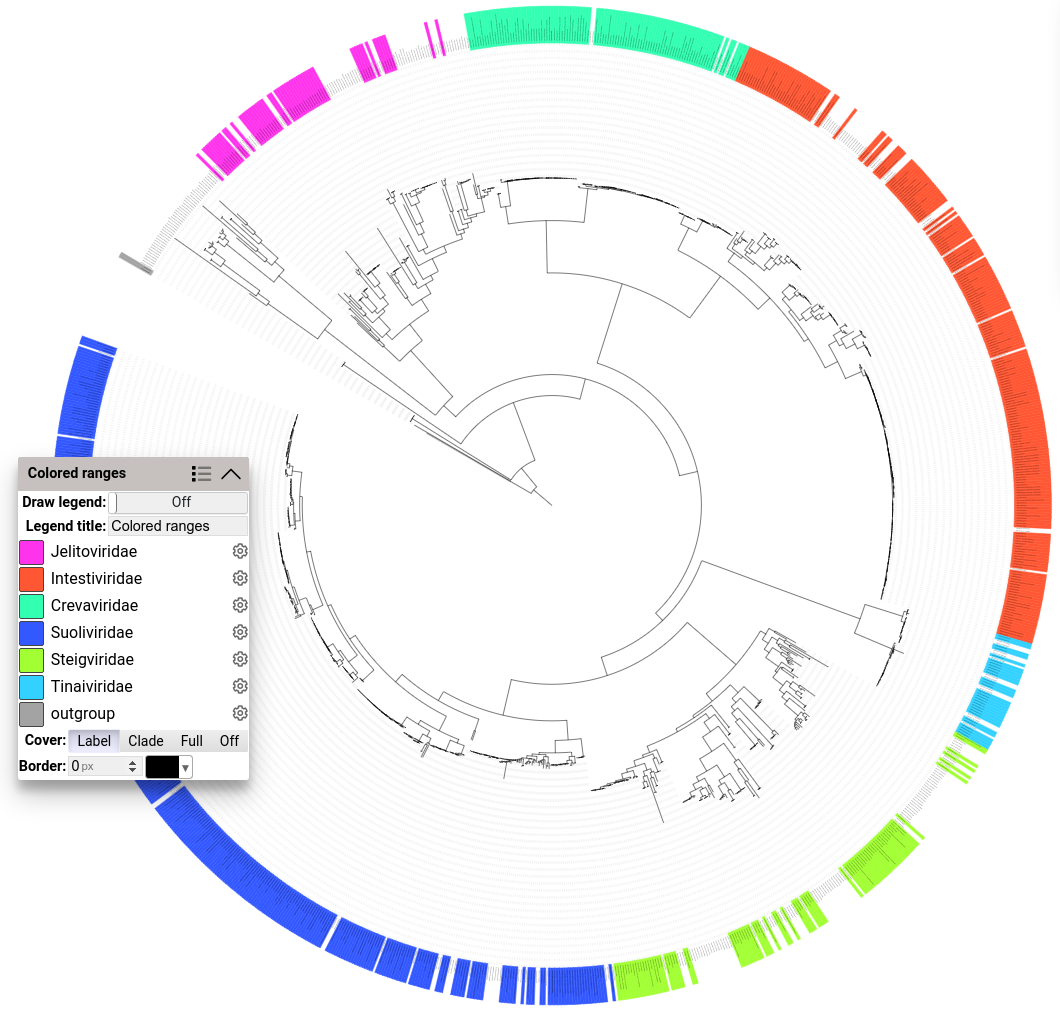

**Since 1k iterations only takes 2 more minutes, I use FFT-NS-1000.**

<span style="color:red">**WATCH OUT!!**</span>. **It does not solve the problem completely**, NB the long clade is still within the monophyletic clade of crAssphages. So, two possibilities: it is because of the `--add` parameter, or because I am not using `mafft-einsi`. Hopefully it is the add parameter because mafft-einsi takes too long. I align with mafft FFT-NS-1000 **without the `--add` parameter** -> 37 minutes, too long. 7 minutes with FFT-NS-I. <span style="color:red">In both trees the long clade is still within the crass clade</span>. So it is because of the alignment method. TRY TO MAKE A MIX OF EINSI AND NORMAL USING THE PARAMETERS.

```
(base) danielc@mutant14:[SCREEN]:/linuxhome/tmp/danielc/terl_distant:cp terl_ref_distant.faa ~/projects/crAssUS/mafft_test/

# 1000 iter
(mafft_env) danielc@encode:~/projects/crAssUS/mafft_test:time mafft-fftnsi --maxiterate 1000 --thread 4 terl_ref_distant.faa > without_add/mafft-einsi.fftnsi1000

# 2 iter
(mafft_env) danielc@encode:~/projects/crAssUS/mafft_test:time mafft-fftnsi --thread 4 terl_ref_distant.faa > without_add/mafft-einsi.fftnsi

# trim
(mafft_env) danielc@encode:~/projects/crAssUS/mafft_test/without_add:~/software/trimAl/source/trimal -in mafft-einsi.fftnsi -out mafft-einsi_trim09.fftnsi -gt 0.9


(mafft_env) danielc@encode:~/projects/crAssUS/mafft_test/without_add:~/software/trimAl/source/trimal -in mafft-einsi.fftnsi1000 -out mafft-einsi_trim09.fftnsi1000 -gt 0.9


# fasttree
(phylogenies) danielc@encode:~/projects/crAssUS/mafft_test/without_add:fasttree mafft-einsi_trim09.fftnsi1000 > mafft-einsi_trim09.fftnsi1000.nwk

(phylogenies) danielc@encode:~/projects/crAssUS/mafft_test/without_add:fasttree mafft-einsi_trim09.fftnsi > mafft-einsi_trim09.fftnsi.nwk
```





Now I have to assess which of the found crAssphages are new genera, and if they are in the same genus. First thing I notice is that 0.7 is too high, I miss some realiable shared genus assignments because of this, such as the `SRR12557723_37_100420` genome with _Kahnovirus_. So I create an entry in `config.yaml` to customize this value, 0.65 by default. This makes some genomes to have 2 genera assigned. It also happened with the 0.7 cutoff. To solve this, one option could be looking at the phylogenies and seeing which of the candidates genera is closest to the genome, but that can vary depending on the marker gene (for most of the genomes should be always the same genus independently of the marker, but in messy regions might change, like for `Serafuli-s-6_181_95801`, _Aurodevirus_ according to TerL and MCP but closest to _Birpovirus_ by portal and shared content). So, I rely in the most similar genus by shared content to discern which is the correct genera. For this, in `taxonomy_from_clustering.py`, the _most_similar_ column will contain the most similar genus, NB I consider only genomes from the reference: if a new crassphage is the most similar, I look at the genus of the second genome, and so on.

Time for the species level now. I want to change the number of species I choose for PyANI. Let's suppose there is one species very similar to other ones, and because of that it gets lots of good (high coverage) alignments with fastani. In order to group all of them into the same species, I need them to be in the file. They will end up in the same bin probably, but in this way I make it sure. They idea I came up with is using a coverage filter in the fastani results instead of a flat 5 genomes selection. But, this is a problem for the short contigs, that are highly covered by almost all the rest of genomes. So pyani would take too long. So I leave it as it is right now, I take the top5 most covered genomes. 

#### Long branches

I have detected some too long branches in the trees. Super weird branches tbh, as if they were not actual TerL, MCP or portal. I think it might related to the evalue or coverage of the profile. I trust more the latter since evalues are quite low in overall.

- **After the analysis, what do I know?** \
`Baboon36B_3443_25547|401|23` is not a fucking portal protein. Why is it annotated then?

In [35]:
from Bio import SearchIO
import pandas as pd
import numpy as np
import glob

# read classification table, filter out "not found" ones
df = pd.read_csv("results/5_phylogenies/taxonomic_classification_completeness.txt", sep="\t", header=0, index_col=0)

# remove not found genomes
df = df[(df["family_portal"] != "Not found") | (df["family_TerL"] != "Not found") | (df["family_MCP"] != "Not found")]


# read file with the marker profiles
marker_profiles_file = "resources/yutin_2021/all_profiles/marker_profiles.txt"
marker_profiles = {line.strip().split("\t")[0]:line.strip().split("\t")[1] for line in open(marker_profiles_file).readlines()}

profiles_length = dict()

domtbl_dir = "results/4_ORF/2_functional_annot/"
for genome in df.index:
    df.loc[genome, "iToL"] = genome.replace("_", " ")
    
    #print(df.loc[genome, ])
    #print(genome)
    hmmsearch_file = glob.glob(f"{domtbl_dir}/{genome}_*.hmmtxt")[0]
    records = SearchIO.parse(hmmsearch_file, "hmmer3-text")
    
    marker_hits = {profile:list() for profile in marker_profiles}
    for record in records:
        if record.id in marker_profiles:
            profiles_length[record.id] = record.seq_len
            for hit in record.hits:
                if hit.bitscore > 15:
                    marker_hits[record.id].append(hit)

    
    # calculate the coverage for all the hits
    profiles_coverage = dict()
    for profile, hits in marker_hits.items():
        # for every profile, look at 
        if hits:
            starts = list()
            ends   = list()
            for hit in hits:
                for hsp in hit.hsps:
                    starts.append(hsp.query_start)
                    ends.append(hsp.query_end)

            intervals = [[s,e] for s,e in zip(starts, ends)]

            intervals.sort(key=lambda interval: interval[0])
            merged = [intervals[0]]
            for current in intervals:
                previous = merged[-1]
                if current[0] <= previous[1]:
                    previous[1] = max(previous[1], current[1])
                else:
                    merged.append(current)

            # calculate coverage
            covered_length = float(0)
            for interval in merged:
                covered_length += 1 + (interval[1] - interval[0])
            
            coverage = float(covered_length/profiles_length[profile])
            profiles_coverage[profile] = coverage
            
            
    # gather profiles by the type of profile they are
    marker_type = {"TerL":list(), "MCP":list(), "portal":list()}
    for profile in profiles_coverage:
        marker_type[marker_profiles[profile]].append([profile, profiles_coverage[profile]])
            
            # get the best coverage per profile type
    for type_marker, profiles_cov in marker_type.items():
        if profiles_cov:
            best_profile = sorted(profiles_cov, key=lambda profile: profile[1], reverse=True)[0]
            # add cov to the table
            df.loc[genome, f"cov_{type_marker}"] = best_profile[1]
            
                
                
df

,completeness,reference,family_portal,subfamily_portal,genus_portal,family_TerL,subfamily_TerL,genus_TerL,family_MCP,subfamily_MCP,genus_MCP,iToL,cov_TerL,cov_MCP,cov_portal
Baboon19_10628_10539,NaN,NaN,Not found,Not found,Not found,unknown,unknown,unknown,Not found,Not found,Not found,Baboon19 10628 10539,0.262204,NaN,NaN
Baboon19_1239_39950,42.49,Grehyhuvirus,Intestiviridae,Obtuvirinae,unknown,Intestiviridae,Obtuvirinae,unknown,Intestiviridae,Obtuvirinae,Grehyhuvirus,Baboon19 1239 39950,0.966374,0.935950,0.993663
Baboon19_13142_9052,9.15,Asinivirinae,Not found,Not found,Not found,Steigviridae,Asinivirinae,unknown,Not found,Not found,Not found,Baboon19 13142 9052,0.872807,NaN,NaN
Baboon19_140_109222,110.39,Asinivirinae,Steigviridae,Asinivirinae,unknown,Steigviridae,Asinivirinae,unknown,Steigviridae,Asinivirinae,unknown,Baboon19 140 109222,0.952580,0.829659,0.988593
Baboon19_1437_36985,20.89,Grossvirinae,Jelitoviridae,Grossvirinae,unknown,Jelitoviridae,Grossvirinae,unknown,Not found,Not found,Not found,Baboon19 1437 36985,0.986859,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Serafuli-s-7_121_101881,100.00,DTR,Suoliviridae,Oafivirinae,Burzaovirus,Suoliviridae,Oafivirinae,Burzaovirus,Suoliviridae,Oafivirinae,Burzaovirus,Serafuli-s-7 121 101881,1.001462,0.997959,0.992966
Serafuli-s-7_128_98160,98.86,Aurodevirus,Suoliviridae,Uncouvirinae,unknown,Suoliviridae,Uncouvirinae,Aurodevirus,Suoliviridae,Uncouvirinae,unknown,Serafuli-s-7 128 98160,1.001462,0.995918,0.992966
Serafuli-s-7_2083_18234,18.43,Asinivirinae,Steigviridae,Asinivirinae,unknown,Steigviridae,Asinivirinae,unknown,Not found,Not found,Not found,Serafuli-s-7 2083 18234,0.986053,NaN,0.780735
Serafuli-s-7_6503_7418,7.35,Oafivirinae,Suoliviridae,Oafivirinae,unknown,Not found,Not found,Not found,Not found,Not found,Not found,Serafuli-s-7 6503 7418,0.258772,NaN,0.810082


In [36]:
# iterate the genomes and look their genome tables to mark partial markers as "NaN"
genome_tables_dir = "results/4_ORF/2_functional_annot_tables"
markers = ["TerL", "MCP", "portal"]
for genome in df.index:
    table_file = glob.glob(f"{genome_tables_dir}/{genome}_*.table")[0]
    table_df = pd.read_csv(table_file, header=0, sep="\t", index_col=0)

    for protein in table_df.index:
        if table_df.loc[protein, "yutin"] in markers and table_df.loc[protein, "partial"]:
            marker = table_df.loc[protein, "yutin"]
            df.loc[genome, f"cov_{marker}"] = np.NaN

In [ ]:
df[df["reference"].isna()]

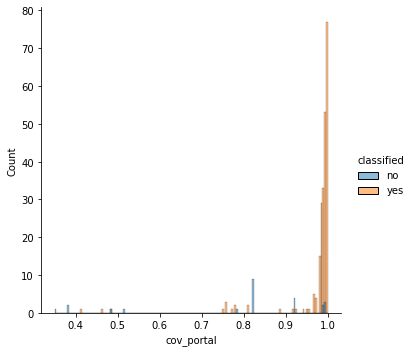

In [37]:
# plot densities
import seaborn as sns
# create a column called "classified", with "yes" or "no".
for genome in df.index:
    # NaN are floats actually. "reference" column contains float for the unknown then
    if isinstance(df.loc[genome, "reference"], float):
        df.loc[genome, "classified"] = "no"
    else:
        df.loc[genome, "classified"] = "yes"
        

sns.displot(df, x="cov_portal", hue="classified")

In [49]:
df[(df["classified"] == "yes") & (df["cov_TerL"] < 0.6)].sort_values("completeness")

,completeness,reference,family_portal,subfamily_portal,genus_portal,family_TerL,subfamily_TerL,genus_TerL,family_MCP,subfamily_MCP,genus_MCP,iToL,cov_TerL,cov_MCP,cov_portal,classified
Howler2_10189_7569,4.27,Grossvirinae,Not found,Not found,Not found,Jelitoviridae,Grossvirinae,unknown,Not found,Not found,Not found,Howler2 10189 7569,0.434954,NaN,NaN,yes
Howler1_9158_9241,5.22,Grossvirinae,Not found,Not found,Not found,Jelitoviridae,Grossvirinae,unknown,Not found,Not found,Not found,Howler1 9158 9241,0.446781,NaN,NaN,yes
Chimp25_6165_5578,5.64,Asinivirinae,Not found,Not found,Not found,Steigviridae,Asinivirinae,unknown,Not found,Not found,Not found,Chimp25 6165 5578,0.260809,NaN,NaN,yes
Howler1_12509_7287,7.36,Asinivirinae,Not found,Not found,Not found,Steigviridae,Asinivirinae,unknown,Not found,Not found,Not found,Howler1 12509 7287,0.364035,NaN,NaN,yes
Howler1_5328_13521,7.64,Grossvirinae,Not found,Not found,Not found,Jelitoviridae,Grossvirinae,unknown,Not found,Not found,Not found,Howler1 5328 13521,0.434954,NaN,NaN,yes
Howler2_4282_13540,7.65,Grossvirinae,Jelitoviridae,Grossvirinae,unknown,Jelitoviridae,Grossvirinae,unknown,Not found,Not found,Not found,Howler2 4282 13540,0.547963,NaN,0.985876,yes
Howler1_5271_13611,7.69,Grossvirinae,Jelitoviridae,Grossvirinae,unknown,Jelitoviridae,Grossvirinae,unknown,Not found,Not found,Not found,Howler1 5271 13611,0.547963,NaN,0.985876,yes
Howler2_4034_14032,7.92,Grossvirinae,Not found,Not found,Not found,Jelitoviridae,Grossvirinae,unknown,Not found,Not found,Not found,Howler2 4034 14032,0.445466,NaN,NaN,yes
Howler2_2872_17361,9.80,Grossvirinae,Jelitoviridae,Grossvirinae,unknown,Jelitoviridae,Grossvirinae,unknown,Not found,Not found,Not found,Howler2 2872 17361,0.554094,NaN,1.000000,yes
Howler3_4913_17483,9.87,Grossvirinae,Jelitoviridae,Grossvirinae,unknown,Jelitoviridae,Grossvirinae,unknown,Not found,Not found,Not found,Howler3 4913 17483,0.554094,NaN,1.000000,yes


In [87]:
df.loc["SRR12557720_11_150680",]

completeness                        100.0
reference                             DTR
family_portal                Tinaiviridae
subfamily_portal             Lumpivirinae
genus_portal                   Rodbovirus
family_TerL                  Tinaiviridae
subfamily_TerL               Lumpivirinae
genus_TerL                     Rodbovirus
family_MCP                   Tinaiviridae
subfamily_MCP                Lumpivirinae
genus_MCP                      Rodbovirus
iToL                SRR12557720 11 150680
cov_TerL                         0.748954
cov_MCP                          0.535124
cov_portal                       0.980989
classified                            yes
Name: SRR12557720_11_150680, dtype: object

Now, put in a tree the coverage information + the length of the protein in percentage of the profile:

In [88]:
# read taxonomy file and save it in a dict
crass_taxonomy = dict()

tax_file = "resources/crass_taxonomy.txt"
lines = [line.strip().split("\t") for line in open(tax_file).readlines()]

families = sorted(list(set([line[2] for line in lines])))
families.remove("outgroup")
subfamilies = list(set([line[3] for line in lines]))
genera = list(set([line[4] for line in lines]))


for line in lines:
    crass_taxonomy[line[0]] = {
                               "family":line[2],
                               "subfamily":line[3],
                               "genus":line[4]
                              }
    

# function to color the squares
def color_squares(node, df, column):
    genome = node.genome
    # get the value from the colum provided
    value = df.loc[genome, column]
    
    if value < 0.1:
        color = "black"
    elif 0.1 >= value < 0.2:
        color = "#D53E4F"
    elif 0.2 >= value < 0.3:
        color = "#F46D43"
    elif 0.3 >= value < 0.4:
        color = "#FDAE61"
    elif 0.4 >= value < 0.5:
        color = "#FEE08B"
    elif 0.5 >= value < 0.6:
        color = "#FFFFBF"
    elif 0.6 >= value < 0.7:
        color = "#E6F598"
    elif 0.7 >= value < 0.8:
        color = "#ABDDA4"
    elif 0.8 >= value < 0.9:
        color = "#66C2A5"
    else:
        color = "#3288BD"
    
    return [color, value]
    
    
    
    
#cmap = colors.ListedColormap(["", "", "", "", "", "", "", "", "", "])
# list trees
colors = ["red","cyan", "green", "orange", "pink", "brown", "grey"]
fams_cols = {fam:col for fam, col in zip(families, colors)}

ts = TreeStyle()
ts.show_leaf_name = False
ts.mode = "c"

trees_files = glob.glob("results/5_phylogenies/2_trees/*.nwk")
for tree_file in trees_files:
    marker = os.path.basename(tree_file).replace("_trimmed.nwk", "")
    print(marker)

    t = Tree(tree_file, format=1)
    # assign taxonomy
    for leaf in t.iter_leaves():
        # check if the leaf comes from the reference set
        genome = leaf.name.split("|")[0]
        if genome in crass_taxonomy:    
            leaf.add_features(family=crass_taxonomy[genome]["family"],
                              subfamily=crass_taxonomy[genome]["subfamily"],
                              genus=crass_taxonomy[genome]["genus"],
                              genome=genome)
        else:
            leaf.add_features(family="new",
                              subfamily="new",
                              genus="new",
                              genome=genome)
           ## add RectFace
           #color, value = color_squares(leaf, df, f"cov_{marker}")
           #face = RectFace(10, 10, color, color, label=str(round(value, 2)))
           #leaf.add_face(face, column=1)
    
    # change leaves style
    for node in t.traverse():
        if node.is_leaf():
            if node.genome in crass_taxonomy and node.genome not in ["NC_021803", "TARA_MK892509"]:
                node.img_style["fgcolor"] = fams_cols[node.family]
                node.img_style["size"] = 2
                node.add_face(TextFace(f"{crass_taxonomy[node.genome]['subfamily']},{crass_taxonomy[node.genome]['genus']}"), column=0, position = "branch-right")
            elif node.genome not in ["NC_021803", "TARA_MK892509"]:
                node.add_face(TextFace(node.name), column=0, position = "branch-right")
                # get color for the background
                color, value = color_squares(node, df, f"cov_{marker}")
                node.img_style["bgcolor"] = color
            
    # find the LCA of the two outgroup species
    outgs_leaves = t.search_nodes(family="outgroup")
    outgs_lca = t.get_common_ancestor(outgs_leaves)
    # reroot the tree 
    t.set_outgroup(outgs_lca)
    
    
    for family in families:
        fam_leaves = t.search_nodes(family=family)
        fam_lca = t.get_common_ancestor(fam_leaves)
        # color branches according to the family
        for node in fam_lca.traverse():
            node.img_style['hz_line_color'] = fams_cols[family] 
            node.img_style['vt_line_color'] = fams_cols[family] 
            node.img_style['size'] = 0
    t.show(tree_style=ts)


portal
MCP
TerL


Looking at the coverage of the profile does not seem the correct approach for this. At the end, it is a sort of proxy for phylogenetic signal: the higher the coverage, the more similar the sequence is and then the closer is the phylogenetic relationship. 

So, to get rid of the weird stuff, it would be more convenient to look at the sharing percentage with known crassphages. I should look at this AFTER assigning taxa based on sharing percentage to see if any of the _unknown_ genomes falls within a monophyletic clade. I improve the shared taxa handling in `prot sharing assignments and agreement across markers`. 

Now I am ready to handle the _unknown_ species, rule `assess_unknown_genomes`. As output, it gives a table with all the unknown genomes, their nprots and their sharing percentages to classified and unclassified genomes. My idea is to remove them from the tree (`node.detach` should work I think) based on their sharing value to classified crass and nprots. I need cutoffs for this tho. 

In [194]:
remove = pd.read_csv("results/5_phylogenies/unknown_genomes.txt", sep="\t", header=0, index_col=0)
remove

# read taxonomy file and save it in a dict
crass_taxonomy = dict()

tax_file = "resources/crass_taxonomy.txt"
lines = [line.strip().split("\t") for line in open(tax_file).readlines()]

families = sorted(list(set([line[2] for line in lines])))
colors = ["red","cyan", "green", "orange", "pink", "brown", "grey"]
fams_cols = {fam:col for fam, col in zip(families, colors)}


for line in lines:
    crass_taxonomy[line[0]] = {
                               "family":line[2],
                               "subfamily":line[3],
                               "genus":line[4]
                              }

ts = TreeStyle()
ts.show_leaf_name = False
ts.mode = "c"

# test with the TerL tree
t = Tree("results/5_phylogenies/2_trees/TerL_trimmed.nwk",format=1)
for leaf in t.iter_leaves():
    # check if the leaf comes from the reference set
    genome = leaf.name.split("|")[0]
    if genome in crass_taxonomy:    
        leaf.add_features(family=crass_taxonomy[genome]["family"],
                          subfamily=crass_taxonomy[genome]["subfamily"],
                          genus=crass_taxonomy[genome]["genus"],
                          genome=genome)
    else:
        if genome in remove.index:
            leaf.add_features(family="unknown",
                               genome=genome)
        else:
            leaf.add_features(family="new",
                               genome=genome)
            
            
# find the LCA of the two outgroup species
outgs_leaves = t.search_nodes(family="outgroup")
outgs_lca = t.get_common_ancestor(outgs_leaves)
# reroot the tree 
t.set_outgroup(outgs_lca)
for family in families:
    fam_leaves = t.search_nodes(family=family)
    fam_lca = t.get_common_ancestor(fam_leaves)
    # color branches according to the family
    for node in fam_lca.traverse():
        node.img_style['hz_line_color'] = fams_cols[family] 
        node.img_style['vt_line_color'] = fams_cols[family] 
        node.img_style['size'] = 0

        
lcas = t.get_monophyletic(values=["unknown"], target_attr="family")

# if monophyletic clades containing new_genus and new genomes were found, iterate them
if lcas:
    # iterate the lcas
    for lca in lcas:
        print(lca)
        #new_genus_leaves = lca.search_nodes(genus=new_genus)
        ## to get the common ancestor, it does not work if there is only one leaf
        #if len(new_genus_leaves) > 1:
        #    final_lca = lca.get_common_ancestor(new_genus_leaves)
            
            
            
            
            
            
t.show(tree_style=ts)

NameError: name 'TreeStyle' is not defined

#### Family monophyletic clades
Look at the issue on GitHub. I have seen some contigs that would get classified just by applying the monophyletic clades method at the family level. Actually it would be just applying to the classification a second round of monophyly assessment with the information obtained from other trees. I implement this in the commit `other markers to expand monoph clades in the initial assessment`.

---
### RefSeq test

I am really curious to know if what it is said in this recent manuscript, that they don't hit any other virus from RefSeq, it is true. I download all the genomes from https://ftp.ncbi.nlm.nih.gov/refseq/release/viral/ and put them under `/projects/Tests/crAssUS_RefSeq_viral/data`. 

```
(crassus_dev) danielc@mutant4:[SCREEN]:~/projects/Tests/crAssUS_RefSeq_viral:snakemake -j95 --use-conda -p
```

Hits this + outgroup sequences:
- `NC_021788.1 Cellulophaga phage phi4:1, complete genome`
- `NC_021798.1 Cellulophaga phage phi17:2, complete genome`
- `NC_031912.1 Flavobacterium phage Fpv20, complete genome`
- `NC_031931.1 Flavobacterium phage Fpv2, complete genome`
- `NC_031914.1 Flavobacterium phage Fpv1, complete genome`
- `NC_041872.1 Flavobacterium phage FpV4, complete genome`

---
### Genomes completeness

Given that I am using just a 5Kb filter, I need a way to assess the completeness of the contigs. 

From Yutin 2021: _To limit the analyzed dataset to complete, fully assembled genomes, 95,663 “circular” contigs (50–200 bp direct overlap at contig ends) were extracted from the assemblies._ So a good initial step could be assessing if they are **DTR** complete or not. Rule `run_DTR_blast`

**Idea:** _What if I calculate the average length (with standar deviation etc) and assess the completeness based on the number of the highest rank that I could assign? If it is genus, I calculate the completeness based on that genus; if it is subfamily, based on the subfamily; and so on_

I run checkV on my contigs

I add a rule to get the distances in the tree, only for the crAssUS contigs tho. **Why did I want to do this? I think that as a measure of replacing the current taxonomic classification with the trees**

Get the average length, per rank:

In [26]:
# read taxonomy file and save it in a dict
# parse genome length too
crass_taxonomy = dict()

tax_file = "container/crass_taxonomy.txt"
genome_dir = "container/genomes"
lines = [line.strip().split("\t") for line in open(tax_file).readlines()]
for line in lines:
    fasta_genome = f"{genome_dir}/{line[0]}.fasta"
    if os.path.isfile(fasta_genome):
        record = SeqIO.read(fasta_genome, "fasta")
        length = len(record.seq)
        crass_taxonomy[line[0]] = {
                                   "family":line[2],
                                   "subfamily":line[3],
                                   "genus":line[4],
                                   "length":length
                                  }

# get all the different ranks so I can store their average lengths
taxas = list()
for genome, ranks in crass_taxonomy.items():
    for rank in ranks:
        if rank != "length":
            taxas.append(crass_taxonomy[genome][rank])

taxas = list(set(taxas))

# iterate the crass_taxonomy dict and store the lengths for each taxa, these being the keys this time
taxas_lengths = {taxa:list() for taxa in taxas}
for genome, ranks in crass_taxonomy.items():
    for rank in ranks:
        if rank != "length":
            taxas_lengths[crass_taxonomy[genome][rank]].append(crass_taxonomy[genome]["length"])

with open("resources/taxas_average_length.txt", "w") as fout:
    for taxa, lengths in taxas_lengths.items():
        average = np.average(lengths)
        fout.write(f"{taxa}\t{average}\n")

---
### Summarize results

I want to see how concordant are the results. Basically I want to know if all the markers make the same prediction.

In [40]:
#import pandas as pd

# read prediction table
df = pd.read_csv("results/5_phylogenies/taxonomic_classification_completeness.txt", sep="\t", header=0, index_col=0)
print("all ->", df.shape[0])

# get not found genomes
not_found = df[(df["family_portal"] == "Not found") & (df["family_TerL"] == "Not found") & (df["family_MCP"] == "Not found")]
print("not found ->", not_found.shape[0], round(not_found.shape[0]/df.shape[0],4 ))

# get unknown genomes
unknown = df[(df["family_portal"] == "unknown") | (df["family_TerL"] == "unknown") | (df["family_MCP"] == "unknown")]
print("unknown ->", unknown.shape[0], round(unknown.shape[0]/df.shape[0],4 ))

all -> 452
not found -> 45 0.0996
unknown -> 70 0.1549


In [31]:
unknown

,completeness,reference,family_portal,subfamily_portal,genus_portal,family_TerL,subfamily_TerL,genus_TerL,family_MCP,subfamily_MCP,genus_MCP
Baboon19_10628_10539,NaN,NaN,Not found,Not found,Not found,unknown,unknown,unknown,Not found,Not found,Not found
Baboon19_1451_36850,NaN,NaN,Not found,Not found,Not found,unknown,unknown,unknown,Not found,Not found,Not found
Baboon19_16211_7770,NaN,NaN,unknown,unknown,unknown,Not found,Not found,Not found,Not found,Not found,Not found
Baboon19_4536_18809,NaN,NaN,unknown,unknown,unknown,unknown,unknown,unknown,Not found,Not found,Not found
Baboon19_894_46906,NaN,NaN,unknown,unknown,unknown,Not found,Not found,Not found,Not found,Not found,Not found
...,...,...,...,...,...,...,...,...,...,...,...
SRR12557734_35869_7104,NaN,NaN,Not found,Not found,Not found,unknown,unknown,unknown,Not found,Not found,Not found
SRR12557734_7555_24191,NaN,NaN,Not found,Not found,Not found,unknown,unknown,unknown,Not found,Not found,Not found
Serafuli-s-6_1007_38274,100.0,DTR,Not found,Not found,Not found,unknown,unknown,unknown,Not found,Not found,Not found
Serafuli-s-6_6335_9777,NaN,NaN,unknown,unknown,unknown,Not found,Not found,Not found,Not found,Not found,Not found


---
### Genomes comparisons

So. time for the fastANI & PyANI thing. Running it is easy, I alreadh have it implemented. The tricky part is what to do with it, as with the sharing information. One thing to do for sure is plotting to the most similar genome. 
I pick the most covering genome given by PyANI, and run megablast with it. To show the results, I need a file in the format of the genome tables that I have for my main project. For the found genomes, I create it with the script `create_genome_tables.py`, rule `create_genome_table` from `open_reading_frames.smk`. Now I need genome tables for the reference genomes, present in the `resources/genomes` folder. Script `create_ref_genomes_tables.py`. I just read the genome tables I already have for them and grab the specific columns I need.

Mmm I am not happy with how PyANI and megablast analyses are connected, with dummy `.done` files. This might be problematic in the future, but it also difficult to put in in a checkpoint because the output is not a folder but specific files. Maybe it is possible with checkpoints, but I could not see how (so far). I notice that actually all the samples can go through PyANI because there will be always a selfhit since I am using all the genomes as a database, including the genome itself. So, no need to checkpoints for avoiding PyANI fail. Same with megablast, I can blast it to itself with no problem.

Jeroen sent me an R package called `gggenomes` (of course). It looks amazing, but it is not available in conda yet. So I need to install it in the Rscript. I will use a different env for this, `plot_genomes.yaml`, with the dependencies for `gggenomes`. The actual installation I do in the rule `install_gggenomes`. 


---
### Writing

- We increase the resolution of the taxonomic classification by using several marker genes. **Do they agree? Check it and highlight it**.

## TESTS



The usage of different genetic codes has been reported previously in crAss-like phages, namely the standard code for Bacteria and Archaea (or genetic code 11), standard code with reassignment of the TGA stop codon to tryptophan and standard code with reassignment of the TAG stop codon to glutamine (Guerin et al., 2018; Yutin et al., 2021). A common approach to identify the genetic code in a crAss-phage has been looking at how fragmented are certain conserved genes (ie. terminase, major capsid or portal proteins) because of the presence of the TAG or TGA stop codons. Here we use a different approach where the coding density and the length 


In [112]:
a = [1,2,3,4]
b = [5,6,7,8]
c = a+b
x = ["first"] * len(a)
y = ["second"] * len(b)
z = x+y
j = pd.DataFrame("set":z, "values":c

SyntaxError: invalid syntax (2926451594.py, line 7)

In [124]:
penguins = sns.load_dataset("penguins")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
